In [1]:
##imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

# Importação dos Dados

In [2]:
df_train = pd.read_csv('./data/treino_309.csv')
df_test = pd.read_csv('./data/preprocessed_test.csv.gz', compression='gzip', sep='\t')

In [3]:
def create_split(df, target, drop_end=1):
    df = df.dropna()
    if 'PROPHET_NORM_FEATURES' in df.columns.values:
        df.drop(['PROPHET_NORM_FEATURES'], inplace=True, axis=1)
    if 'NEURO_LABEL' in df.columns.values:
        df.drop(['NEURO_LABEL'], inplace=True, axis=1)
    if 'PROPHET_LABEL' in df.columns.values:
        df.drop(['PROPHET_LABEL'], inplace=True, axis=1)
    return df[df.columns[:len(df.columns)-drop_end]].to_numpy(), df[[target]].to_numpy().reshape(-1)

In [4]:
df = df_train.drop(['PROPHET_NORM_FEATURES', 'NEURO_LABEL', 'Unnamed: 0'], axis = 1).append(df_test.drop(['PROPHET_NORM_FEATURES', 'NEURO_LABEL'], axis = 1))

In [5]:
X = df[df.columns].drop(['ALVO'], axis=1)

In [6]:
X.drop('PROPHET_LABEL', axis=1, inplace=True)

In [7]:
y = df.ALVO

In [8]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor().fit(X, y)
tree.feature_importances_

array([9.08467726e-03, 1.65250584e-02, 3.28695561e-02, 1.49525465e-02,
       1.97277307e-04, 2.99919140e-04, 5.12269323e-04, 1.70814570e-03,
       7.77580647e-04, 6.32680646e-03, 0.00000000e+00, 6.06583209e-04,
       7.85454546e-04, 2.06491365e-03, 1.18990718e-03, 5.88353183e-04,
       9.66964032e-04, 1.33494556e-03, 0.00000000e+00, 1.47316539e-03,
       7.42635165e-04, 2.14059778e-03, 9.56356811e-04, 2.19160907e-03,
       0.00000000e+00, 4.16283200e-04, 7.02743608e-04, 6.19674906e-04,
       1.23576350e-03, 1.16679837e-03, 1.52252927e-03, 9.33371575e-04,
       4.19563548e-04, 1.39311076e-03, 1.41392945e-03, 9.07199720e-04,
       0.00000000e+00, 7.15213023e-04, 6.30818383e-04, 0.00000000e+00,
       1.11680238e-03, 7.69537290e-04, 1.75439487e-03, 1.03205409e-03,
       1.04628330e-03, 1.74956804e-03, 1.65381122e-03, 9.30191277e-04,
       0.00000000e+00, 6.47308236e-04, 1.40333284e-03, 1.69106862e-03,
       6.35783108e-04, 1.40206008e-03, 1.36497473e-03, 8.59280811e-04,
      

In [9]:
feat_imp = tree.feature_importances_
cols_to_use = X[X.columns.values[np.where(feat_imp>5e-3)]].columns.values

In [10]:
cols_to_use = np.append(cols_to_use, df_test.columns[0])

In [11]:
df_train = df_train[cols_to_use]
df_test = df_test[cols_to_use]

In [12]:
X_train = df_train[df_train.drop(['ALVO'], axis=1).columns.values]
y_train = df_train.ALVO


In [13]:
X_test = df_test[df_test.drop(['ALVO'], axis=1).columns.values]
y_test = df_test.ALVO

# Primeiro Modelo: Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [72]:
forest = RandomForestClassifier(max_features=6, n_estimators=50)

In [73]:
forest.fit(X_train, y_train)

RandomForestClassifier(max_features=6, n_estimators=50)

In [74]:
y_pred = forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

In [75]:
metrics_dict = {'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1': f1, 'ROC-AUC': roc}

In [76]:
metrics_df = pd.DataFrame(metrics_dict.items(), index = metrics_dict.keys(), columns=['Métrica', 'Valor'])

In [77]:
metrics_df

,Métrica,Valor
Accuracy,Accuracy,0.842709
Recall,Recall,0.961280
Precision,Precision,0.869144
F1,F1,0.912893
ROC-AUC,ROC-AUC,0.545478


<AxesSubplot:>

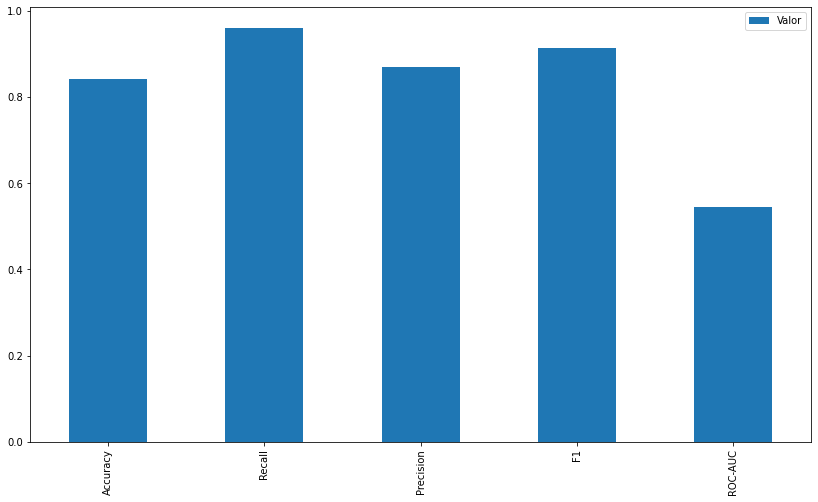

In [78]:
metrics_df.plot(kind='bar',figsize=(14,8))

In [79]:
from scipy.stats import ks_2samp
ks_2samp(y_pred, y_test)

KstestResult(statistic=0.09089266260152108, pvalue=0.0)

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

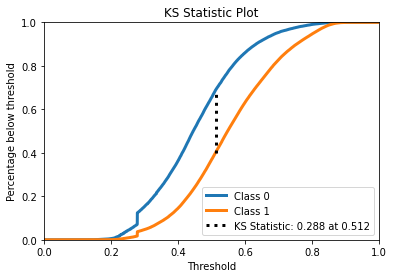

In [80]:
from scikitplot.metrics import plot_ks_statistic

plot_ks_statistic(y_test, gbrt.predict_proba(X_test))

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

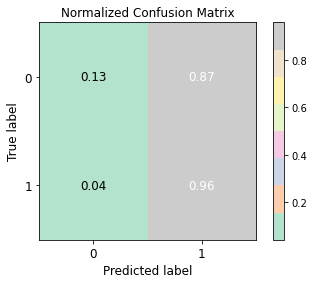

In [81]:
from scikitplot.metrics import plot_confusion_matrix
plot_confusion_matrix(y_test, forest.predict(X_test), normalize = True, cmap = 'Pastel2', text_fontsize = 'large')

# Gradient Boosting

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

In [25]:
gbrt = GradientBoostingClassifier(max_depth = 6, n_estimators = 35)

In [26]:
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=6, n_estimators=35)

In [82]:
y_pred = gbrt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

<AxesSubplot:>

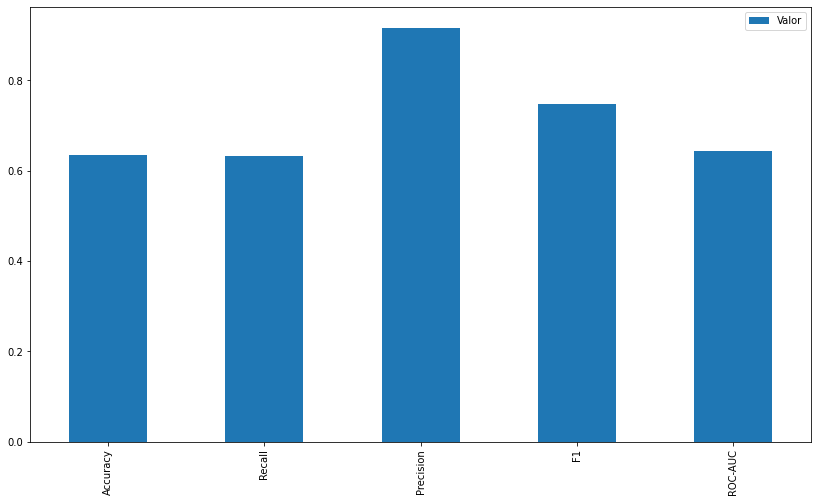

In [83]:
metrics_dict = {'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1': f1, 'ROC-AUC': roc}

metrics_df = pd.DataFrame(metrics_dict.items(), index = metrics_dict.keys(), columns=['Métrica', 'Valor'])

metrics_df.plot(kind='bar',figsize=(14,8))

In [84]:
metrics_df

,Métrica,Valor
Accuracy,Accuracy,0.635412
Recall,Recall,0.632401
Precision,Precision,0.916500
F1,F1,0.748396
ROC-AUC,ROC-AUC,0.642961


In [30]:
from scipy.stats import ks_2samp

ks_2samp(y_test, y_pred)

KstestResult(statistic=0.26578513932847647, pvalue=0.0)

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

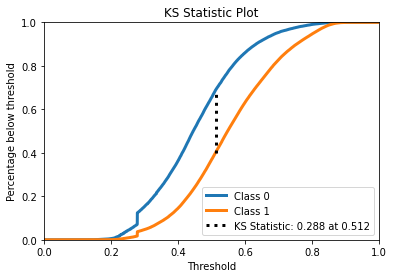

In [31]:
from scikitplot.metrics import plot_ks_statistic

plot_ks_statistic(y_test, gbrt.predict_proba(X_test))

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

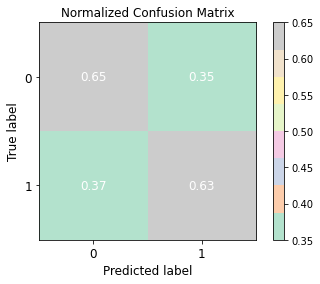

In [66]:
plot_confusion_matrix(y_test, gbrt.predict(X_test), normalize = True, cmap = 'Pastel2', text_fontsize = 'large')

In [ ]:
import pickle
f = open('./models/GradientBoosting', 'wb')
pickle.dump(gbrt, f)

# Ensemble MLP

In [44]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier

In [45]:
baggingClassifier = BaggingClassifier(
    base_estimator = MLPClassifier(hidden_layer_sizes = (16)),
    max_samples = 0.75,
    max_features = 0.75,
    n_estimators = 5
)

In [46]:
baggingClassifier.fit(X_train, y_train)

BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes=16),
                  max_features=0.75, max_samples=0.75, n_estimators=5)

In [47]:
y_pred = baggingClassifier.predict(X_test)

In [48]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

<AxesSubplot:>

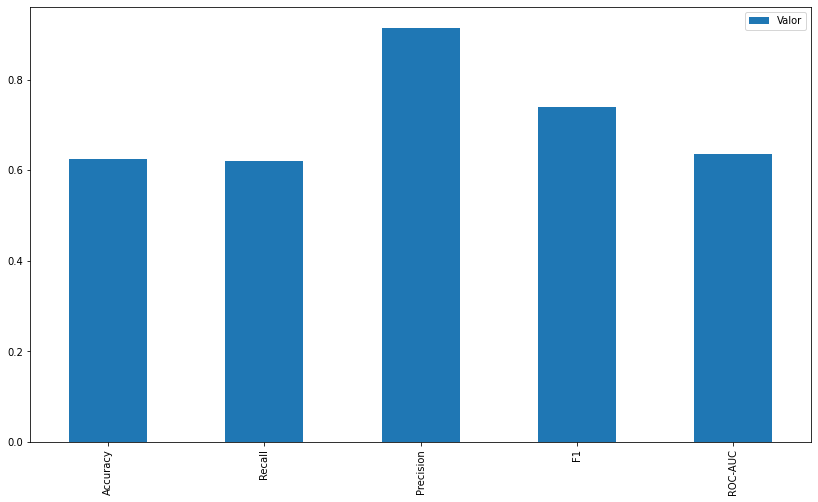

In [49]:
metrics_dict = {'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1': f1, 'ROC-AUC': roc}

metrics_df = pd.DataFrame(metrics_dict.items(), index = metrics_dict.keys(), columns=['Métrica', 'Valor'])

metrics_df.plot(kind='bar',figsize=(14,8))

In [50]:
from scipy.stats import ks_2samp

In [51]:
from scipy.stats import ks_2samp
ks_2samp(y_pred, y_test)

KstestResult(statistic=0.27515631534652696, pvalue=0.0)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

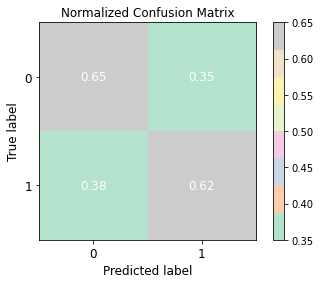

In [64]:
plot_confusion_matrix(y_test, baggingClassifier.predict(X_test), normalize = True, cmap = 'Pastel2', text_fontsize = 'large')

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

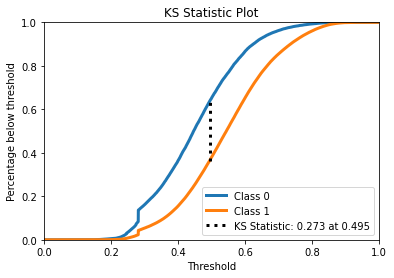

In [53]:
plot_ks_statistic(y_test, baggingClassifier.predict_proba(X_test))

In [67]:
metrics_df

,Métrica,Valor
Accuracy,Accuracy,0.625401
Recall,Recall,0.621098
Precision,Precision,0.914606
F1,F1,0.739804
ROC-AUC,ROC-AUC,0.636187


# MLP

In [94]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes = (50, 50), activation = 'relu', learning_rate_init = 0.001)

In [95]:
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(50, 50))

In [96]:
y_pred = baggingClassifier.predict(X_test)

In [97]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

<AxesSubplot:>

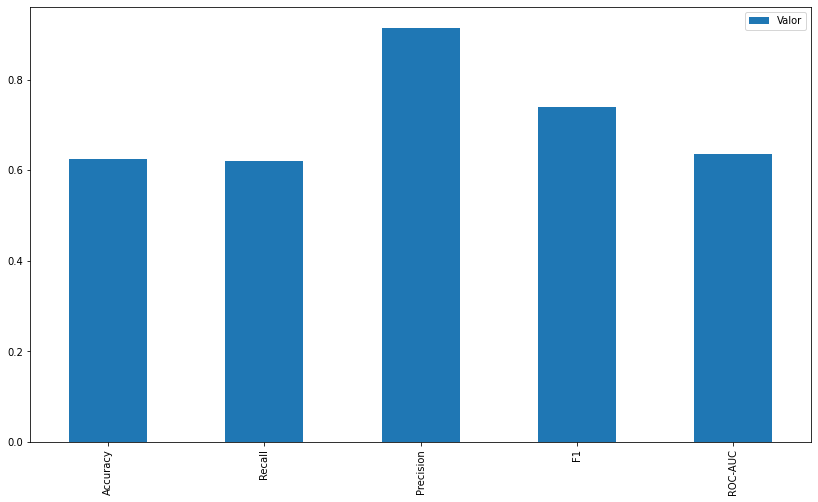

In [98]:
metrics_dict = {'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1': f1, 'ROC-AUC': roc}

metrics_df = pd.DataFrame(metrics_dict.items(), index = metrics_dict.keys(), columns=['Métrica', 'Valor'])

metrics_df.plot(kind='bar',figsize=(14,8))

In [99]:
metrics_df

,Métrica,Valor
Accuracy,Accuracy,0.625401
Recall,Recall,0.621098
Precision,Precision,0.914606
F1,F1,0.739804
ROC-AUC,ROC-AUC,0.636187


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

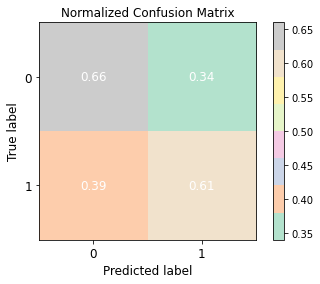

In [100]:
plot_confusion_matrix(y_test, mlp.predict(X_test), normalize = True, cmap = 'Pastel2', text_fontsize = 'large')

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

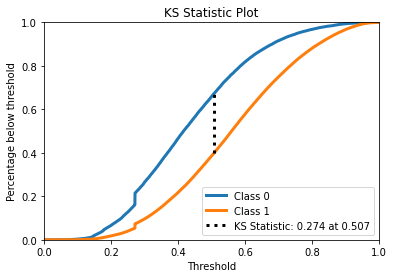

In [101]:
plot_ks_statistic(y_test, mlp.predict_proba(X_test))

# SVM

In [14]:
from sklearn.svm import SVC

final_svm = SVC(random_state = 0,
                kernel = 'poly',
                degree = 3,
                gamma = 'scale',
                max_iter=10000)

In [15]:
final_svm.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


SVC(kernel='poly', max_iter=10000, random_state=0)

In [16]:
y_pred = final_svm.predict(X_test)

In [17]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

<AxesSubplot:>

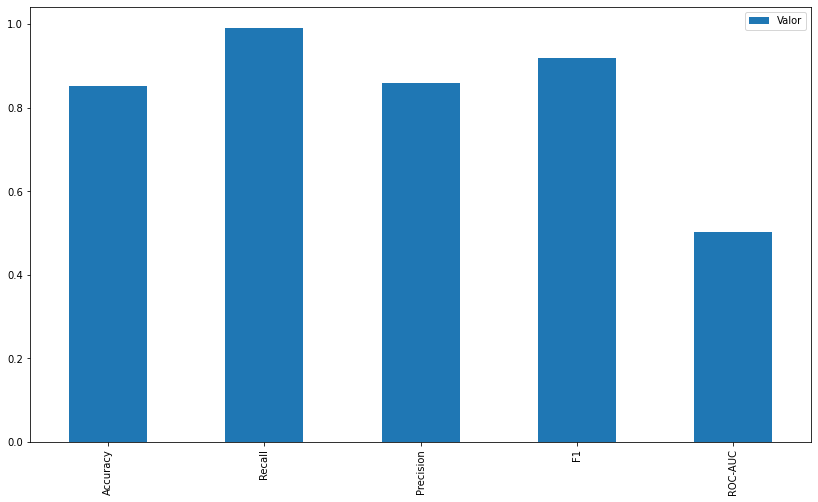

In [18]:
metrics_dict = {'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1': f1, 'ROC-AUC': roc}

metrics_df = pd.DataFrame(metrics_dict.items(), index = metrics_dict.keys(), columns=['Métrica', 'Valor'])

metrics_df.plot(kind='bar',figsize=(14,8))

In [19]:
metrics_df

,Métrica,Valor
Accuracy,Accuracy,0.852214
Recall,Recall,0.991756
Precision,Precision,0.858014
F1,F1,0.920050
ROC-AUC,ROC-AUC,0.502414


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

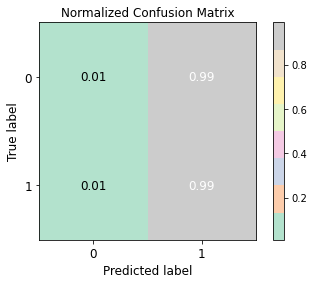

In [20]:
from scikitplot.metrics import plot_confusion_matrix

plot_confusion_matrix(y_test, final_svm.predict(X_test), normalize = True, cmap = 'Pastel2', text_fontsize = 'large')

In [23]:
from scipy.stats import ks_2samp
ks_2samp(y_test, y_pred)

KstestResult(statistic=0.1336489758827751, pvalue=0.0)